Enable automatic reloading of imported modules.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters 

In [2]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_result_by_name, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [3]:
dataset = 'MNIST'
learner_type = 'SVM'
loader_func = load_adult

In [4]:
df = load_mnist(preprocess=True)

Target column encoded with the following classes [ 4.  9.]
Dataset shape (13782, 785)
Value composition:
1    0.504861
0    0.495139
Name: target, dtype: float64


/home/jovyan/loaders.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_df['target'] = le.fit_transform(filtered_df['target'])


### Split data into training and testing

In [5]:
X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [6]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Support Vector Machine Model Complexity
Sources:
1. https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
2. https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

#### Hyperparameters for SVMs

**Kernel:** The kernel function used to perform the "kernel trick"

**C:** Penalty parameter C of the error term.

**gamma:** Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.

In [7]:
from sklearn.svm import LinearSVC

linear_clf = LinearSVC(random_state=1)

linear_param_grid = {
    'C': np.logspace(-3, 2, 6),
    'max_iter': np.logspace(1, 4, 4)
}
linear_param_grid

{'C': array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
          1.00000000e+00,   1.00000000e+01,   1.00000000e+02]),
 'max_iter': array([    10.,    100.,   1000.,  10000.])}

In [8]:
linear_grid_search = GridSearchCV(
    estimator=linear_clf,
    param_grid=linear_param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=-1,
)

In [19]:
linear_grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] . C=0.001, max_iter=10.0, score=0.9535847492747617, total=   0.2s
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] . C=0.001, max_iter=10.0, score=0.9593698175787728, total=   0.2s
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] .. C=0.001, max_iter=10.0, score=0.959767731231854, total=   0.2s
[CV] C=0.001, max_iter=100.0 .........................................
[CV] C=0.001, max_iter=100.0 .........................................
[CV] . C=0.001, max_iter=10.0, score=0.9643301534632932, total=   0.2s
[CV]  C=0.001, max_iter=100.0, score=0.9535847492747617, total=   0.2s
[CV] C=0.001, max_iter=100.0 .........................................
[CV]  C=0.001, max_iter=100.0, score=0.9593698175787728, total=   0.2s
[CV] C=0.001, ma

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s


[CV]  C=0.001, max_iter=1000.0, score=0.959767731231854, total=   0.2s
[CV] C=0.001, max_iter=10000.0 .......................................
[CV] C=0.001, max_iter=10000.0 .......................................
[CV]  C=0.001, max_iter=1000.0, score=0.9643301534632932, total=   0.2s
[CV] C=0.001, max_iter=10000.0 .......................................
[CV]  C=0.001, max_iter=10000.0, score=0.9535847492747617, total=   0.2s
[CV]  C=0.001, max_iter=10000.0, score=0.9593698175787728, total=   0.2s
[CV] C=0.001, max_iter=10000.0 .......................................
[CV]  C=0.001, max_iter=10000.0, score=0.959767731231854, total=   0.2s
[CV] C=0.01, max_iter=10.0 ...........................................
[CV]  C=0.001, max_iter=10000.0, score=0.9643301534632932, total=   0.2s
[CV] C=0.01, max_iter=10.0 ...........................................
[CV] ... C=0.01, max_iter=10.0, score=0.966017405719022, total=   0.1s
[CV] .. C=0.01, max_iter=10.0, score=0.9697346600331676, total=   0.1

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s


[CV] C=0.01, max_iter=100.0 ..........................................
[CV] .. C=0.01, max_iter=10.0, score=0.9701368726669432, total=   0.1s
[CV] C=0.01, max_iter=100.0 ..........................................
[CV] . C=0.01, max_iter=100.0, score=0.9664318276004973, total=   0.1s
[CV] C=0.01, max_iter=100.0 ..........................................
[CV] . C=0.01, max_iter=100.0, score=0.9693200663349917, total=   0.2s
[CV] C=0.01, max_iter=100.0 ..........................................
[CV] . C=0.01, max_iter=100.0, score=0.9655744504355039, total=   0.2s
[CV] C=0.01, max_iter=1000.0 .........................................
[CV] . C=0.01, max_iter=100.0, score=0.9705516383243468, total=   0.2s
[CV] C=0.01, max_iter=1000.0 .........................................
[CV]  C=0.01, max_iter=1000.0, score=0.9664318276004973, total=   0.2s
[CV] C=0.01, max_iter=1000.0 .........................................
[CV]  C=0.01, max_iter=1000.0, score=0.9693200663349917, total=   0.1s
[CV] C

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.4s


[CV]  C=0.01, max_iter=10000.0, score=0.9655744504355039, total=   0.2s
[CV] C=0.1, max_iter=10.0 ............................................
[CV]  C=0.01, max_iter=10000.0, score=0.9705516383243468, total=   0.2s
[CV] C=0.1, max_iter=10.0 ............................................
[CV] ... C=0.1, max_iter=10.0, score=0.9676750932449233, total=   0.1s
[CV] C=0.1, max_iter=10.0 ............................................
[CV] ... C=0.1, max_iter=10.0, score=0.9601990049751243, total=   0.1s
[CV] C=0.1, max_iter=10.0 ............................................
[CV] ... C=0.1, max_iter=10.0, score=0.9576939029448361, total=   0.2s
[CV] C=0.1, max_iter=100.0 ...........................................
[CV] ... C=0.1, max_iter=10.0, score=0.9659892160929076, total=   0.1s
[CV] C=0.1, max_iter=100.0 ...........................................
[CV] ... C=0.1, max_iter=100.0, score=0.966017405719022, total=   0.2s
[CV] C=0.1, max_iter=100.0 ...........................................
[CV]

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.7s


[CV] .. C=0.1, max_iter=1000.0, score=0.966017405719022, total=   0.3s
[CV] C=0.1, max_iter=1000.0 ..........................................
[CV] . C=0.1, max_iter=1000.0, score=0.9701492537313433, total=   0.3s
[CV] C=0.1, max_iter=10000.0 .........................................
[CV] . C=0.1, max_iter=1000.0, score=0.9622563251762754, total=   0.3s
[CV] C=0.1, max_iter=10000.0 .........................................
[CV] . C=0.1, max_iter=1000.0, score=0.9701368726669432, total=   0.3s
[CV] C=0.1, max_iter=10000.0 .........................................
[CV] . C=0.1, max_iter=10000.0, score=0.966017405719022, total=   0.3s
[CV] C=0.1, max_iter=10000.0 .........................................
[CV] C=1.0, max_iter=10.0 ............................................
[CV]  C=0.1, max_iter=10000.0, score=0.9701492537313433, total=   0.4s
[CV] ... C=1.0, max_iter=10.0, score=0.9643597181931206, total=   0.1s
[CV] C=1.0, max_iter=10.0 ............................................
[CV]  

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.4s


[CV] .. C=1.0, max_iter=100.0, score=0.9535462463708005, total=   0.2s
[CV] C=1.0, max_iter=1000.0 ..........................................
[CV] .. C=1.0, max_iter=100.0, score=0.9688925756947325, total=   0.2s
[CV] C=1.0, max_iter=1000.0 ..........................................
[CV] C=1.0, max_iter=1000.0 ..........................................
[CV] C=1.0, max_iter=10000.0 .........................................
[CV] . C=1.0, max_iter=1000.0, score=0.9631164525486946, total=   0.5s
[CV] C=1.0, max_iter=10000.0 .........................................
[CV] C=1.0, max_iter=10000.0 .........................................
[CV] . C=1.0, max_iter=1000.0, score=0.9635157545605307, total=   0.5s
[CV] . C=1.0, max_iter=1000.0, score=0.9589381999170469, total=   0.6s
[CV] C=1.0, max_iter=10000.0 .........................................
[CV] C=10.0, max_iter=10.0 ...........................................
[CV] . C=1.0, max_iter=1000.0, score=0.9684778100373289, total=   0.7s
[CV] C

[Parallel(n_jobs=-1)]: Done  75 out of  96 | elapsed:    9.7s remaining:    2.7s


[CV] C=100.0, max_iter=10.0 ..........................................
[CV]  C=10.0, max_iter=1000.0, score=0.9630858564910826, total=   1.1s
[CV] . C=100.0, max_iter=10.0, score=0.9622563251762754, total=   0.2s
[CV] C=100.0, max_iter=100.0 .........................................
[CV] . C=100.0, max_iter=10.0, score=0.9178763998340937, total=   0.2s
[CV] C=100.0, max_iter=100.0 .........................................
[CV] C=100.0, max_iter=100.0 .........................................
[CV]  C=100.0, max_iter=100.0, score=0.9602154993783671, total=   0.3s
[CV] C=100.0, max_iter=100.0 .........................................
[CV] . C=100.0, max_iter=100.0, score=0.961028192371476, total=   0.3s
[CV] C=100.0, max_iter=1000.0 ........................................
[CV] C=100.0, max_iter=1000.0 ........................................
[CV]  C=100.0, max_iter=100.0, score=0.9523019493985898, total=   0.4s
[CV] C=100.0, max_iter=1000.0 ........................................
[CV]  

[Parallel(n_jobs=-1)]: Done  85 out of  96 | elapsed:   11.3s remaining:    1.5s


[CV] C=100.0, max_iter=10000.0 .......................................
[CV]  C=100.0, max_iter=1000.0, score=0.9506428867689756, total=   0.7s
[CV]  C=100.0, max_iter=1000.0, score=0.9581086686022398, total=   1.0s
[CV]  C=10.0, max_iter=10000.0, score=0.9573145462080398, total=   3.4s
[CV]  C=10.0, max_iter=10000.0, score=0.9523217247097844, total=   3.6s
[CV]  C=10.0, max_iter=10000.0, score=0.9622563251762754, total=   3.7s
[CV]  C=10.0, max_iter=10000.0, score=0.9531314807133969, total=   4.0s
[CV]  C=100.0, max_iter=10000.0, score=0.9423714759535655, total=   2.8s
[CV]  C=100.0, max_iter=10000.0, score=0.9510982179859097, total=   3.1s
[CV]  C=100.0, max_iter=10000.0, score=0.9381999170468686, total=   3.1s
[CV]  C=100.0, max_iter=10000.0, score=0.9552053090004148, total=   3.3s


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   14.8s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'max_iter': array([   10.,   100.,  1000., 10000.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [20]:
save_search_result(linear_grid_search, dataset, learner_type, extras='linear')

In [9]:
from sklearn.svm import SVC

rbf_clf = SVC(kernel='rbf', random_state=1)

rbf_param_grid = {
    'C': np.logspace(-3, 2, 6),
    'max_iter': np.logspace(1, 4, 4),
    'gamma': np.logspace(-4, 1, 6),
}
rbf_param_grid

{'C': array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
          1.00000000e+00,   1.00000000e+01,   1.00000000e+02]),
 'max_iter': array([    10.,    100.,   1000.,  10000.]),
 'gamma': array([  1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
          1.00000000e-01,   1.00000000e+00,   1.00000000e+01])}

In [22]:
rbf_grid_search = GridSearchCV(
    estimator=rbf_clf,
    param_grid=rbf_param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=-1,
)

In [23]:
rbf_grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.7513468711147948, total=   0.3s
[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.7408789386401327, total=   0.3s
[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.7652426379095811, total=   0.3s
[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................
[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................
[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.7552882621318955, total=   0.3s
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.001, max_iter=10.0 .............................
[CV] C=0.001, gamma=0.001, max_iter=10.0 ..........

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.7472026523000415, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................
[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.7408789386401327, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.7822480298631274, total=   0.6s
[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................
[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.7681459975114061, total=   0.5s
[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.7364276833816825, total=   2.6s
[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s


[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.6936152570480929, total=   2.9s
[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.7192036499377852, total=   2.9s
[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.7216922438822065, total=   2.9s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.7259535655058044, total=   2.8s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.7389142146705346, total=   3.0s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.7324761509746993, total=   3.0s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.7295727913728743, total=   3.0s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.6684624948197265, total=  37.5s
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.6395686437163003, total=  37.7s
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.6231343283582089, total=  37.7s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min


[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.8188976377952756, total=   0.6s
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.8092868988391376, total=   0.6s
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................
[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.8145997511406056, total=   0.5s
[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.6213189547905433, total=  38.3s
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................
[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.7648278722521775, total=   0.5s
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.6721922917530045, total=  38.0s
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.6549149730402323, total=  38.2s
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.6401326699834162, total=  38.3s
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.6383243467440896, total=  38.4s
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.8155822627434729, total=   3.6s
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.8109452736318408, total=   3.5s


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.2min


[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.8195769390294484, total=   3.6s
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.8075487349647449, total=   3.7s
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.67882304185661, total=  37.7s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.7367330016583747, total=  37.5s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.6481558226274348, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.705931148900871, total=  37.6s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.7171298216507673, total=  37.9s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.6169154228855721, total=   0.6s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.557445043550394, total=   0.5s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.6569888013272501, total=   0.6s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.3min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated ear

[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.7670949026108579, total=   3.6s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.6832504145936982, total=   3.7s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.671505599336375, total=   3.6s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.643716300290336, total=   3.6s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.9079983423124741, total=  38.6s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.9116915422885572, total=  38.7s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.9249274160099544, total=  38.7s
[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.9220240564081295, total=  38.5s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.5051802735184417, total=   0.6s
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................
[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.5082918739635157, total=   0.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.0min


[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.5002073828287018, total=   0.5s
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................
[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.5089174616341767, total=   0.6s
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.5049751243781094, total= 2.4min


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.5723166183174472, total=   3.7s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.5576285240464345, total=   3.7s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.569888013272501, total=   3.6s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.5387805889672335, total=   3.7s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.01, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.9170812603648425, total=  38.7s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  5.2min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.01, max_iter=10000.0, score=0.5047658516369664, total= 2.4min


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.9021153048527581, total=  38.7s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.9088271860754248, total=  38.8s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.6916701201823456, total=   0.6s
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................
[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.681592039800995, total=   0.5s
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.01, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................
[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.9083367897138117, total=  38.9s
[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.6905848195769391, total=   0.5s
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.7009539610120282, total=   0.5s
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=0.01, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.9067550766680481, total=   3.6s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.9025704809286899, total=   3.6s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.8934052260472832, total=   3.6s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.8975528826213189, total=   3.6s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.9593866556154165, total=  38.7s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.3min


[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.972210700953961, total=  38.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.9610120282040647, total=  38.7s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.7513468711147948, total=   0.6s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.9614427860696517, total=  39.2s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.7408789386401327, total=   0.5s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.7652426379095811, total=   0.6s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................
[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.7552882621318955, total=   0.5s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.7364276833816825, total=   3.7s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.6936152570480929, total=   3.7s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.7192036499377852, total=   3.7s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.7216922438822065, total=   3.6s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.1, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.1, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.1, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.1, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  7.5min


[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6231343283582089, total=  38.8s
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6684624948197265, total=  39.2s
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.7472026523000415, total=   0.5s
[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6370800497718789, total=  39.2s
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.7408789386401327, total=   0.6s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6196598921609291, total=  39.6s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................
[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.7822480298631274, total=   0.5s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................
[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.7681459975114061, total=   0.5s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.7389142146705346, total=   3.7s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.7259535655058044, total=   3.6s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.7324761509746993, total=   3.6s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.7295727913728743, total=   3.6s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=0.01, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=1.0, max_iter=10000.0, score=0.5047658516369664, total= 2.3min
[CV] C=0.01, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=1.0, max_iter=10000.0, score=0.5049751243781094, total

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.6368159203980099, total=  38.7s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.6730211355159552, total=  38.8s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................


[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  8.7min


[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.6586478639568644, total=  38.9s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.8188976377952756, total=   0.5s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.8092868988391376, total=   0.5s
[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.6329323931978432, total=  39.0s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.8145997511406056, total=   0.7s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................
[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.7648278722521775, total=   0.5s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.821798590965603, total=   3.6s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.8084577114427861, total=   3.7s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.8195769390294484, total=   3.6s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.7984238905018665, total=   3.6s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=10.0, max_iter=10000.0, score=0.5049751243781094, total= 2.3min
[CV] C=0.01, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=10.0, max_iter=10000.0, score=0.5047658516369664, total= 2.3min
[CV] C=0.01, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.7596353087443017, total=  38.2s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.6481558226274348, total=   0.6s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................
[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.7603648424543947, total=  38.4s


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  9.9min


[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................
[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.7772708419742845, total=  38.2s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.6169154228855721, total=   0.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.7938614682704273, total=  38.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.557445043550394, total=   0.6s
[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.6569888013272501, total=   0.5s
[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.8002486531288852, total=   3.7s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.6994195688225538, total=   3.7s
[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.6789713811696392, total=   3.7s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.671505599336375, total=   3.6s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.9419568822553898, total=  38.6s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.959767731231854, total=  38.9s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.9605972625466611, total=  38.8s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.9552424368006631, total=  38.9s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.5060091172813924, total=   0.5s
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................
[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.5049751243781094, total=   0.6s
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.5002073828287018, total=   0.5s
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.5089174616341767, total=   0.5s


[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed: 11.4min


[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5698300870285951, total=   3.8s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5518242122719734, total=   3.7s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5802571547075902, total=   3.7s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5620074657818332, total=   3.4s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=0.001, max_iter=10000.0, score=0.5192706174886034, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.001, max_iter=10000.0, score=0.5184570717544588, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.001, max_iter=10000.0, score=0.5118208212360017, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.001, max_iter=10000.0, score=0.5323383084577115, total= 2.4min
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10000.0, score=0.9287194363862412, total= 2.0min
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.01, max_iter=10000.0, score=0.9332504145936982, total= 1.9min
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.692084542063821, total=   0.5s
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.6820066334991708, total=   0.5s
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.01, max_iter=10000.0, score=0.9253421816673579, total= 2.0min


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.6901700539195355, total=   0.6s
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................
[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.702198257984239, total=   0.6s
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10000.0, score=0.9431771049357113, total= 2.0min
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.6min


[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.9067550766680481, total=   3.7s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.9025704809286899, total=   3.7s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.8934052260472832, total=   3.7s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.8951512639867385, total=  39.3s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.9116915422885572, total=  39.2s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.8996267109083368, total=  39.3s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.9029448361675654, total=  39.5s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.8975528826213189, total=   3.2s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.9593866556154165, total=  38.7s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.9614427860696517, total=  38.8s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.7513468711147948, total=   0.6s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.7408789386401327, total=   0.5s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.9610120282040647, total=  39.1s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.972210700953961, total=  38.9s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................
[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.7652426379095811, total=   0.5s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.7552882621318955, total=   0.6s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.7364276833816825, total=   3.7s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.6936152570480929, total=   3.6s
[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.7192036499377852, total=   3.7s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.7216922438822065, total=   3.6s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6692913385826772, total=  38.3s
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................


[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed: 14.9min


[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6163417669017005, total=  38.2s
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6231343283582089, total=  38.8s
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6433015346329324, total=  38.7s
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.5049751243781094, total= 2.3min
[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.7472026523000415, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.7408789386401327, total=   0.5s
[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.7822480298631274, total=   0.6s
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.7681459975114061, total=   0.5s
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.729796933278077, total=   3.6s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.693200663349917, total=   3.7s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.7416009954375777, total=   3.6s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.7353795105765243, total=   3.8s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.7235806050559469, total=  38.6s
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................
[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.6748237245956035, total=  38.4s
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................


[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed: 16.3min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.6521558872305141, total=  38.9s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.807293825113966, total=   0.6s
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................
[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.7997512437810945, total=   0.6s
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.8145997511406056, total=   0.5s
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.7884695147241808, total=   0.5s
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.8280149191877331, total=   3.6s
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.6611364579012857, total=  39.8s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.8233830845771144, total=   3.6s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.8291165491497304, total=   3.6s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.817917876399834, total=   3.6s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=0.1, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=0.1, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.5047658516369664, total= 2.5min
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.5049751243781094, total= 2.5min
[CV] C=0.1, gamma=0.01, max_iter=10000.0 .............................
[CV] C=0.1, gamma=0.01, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.9622876087857439, total=  38.8s
[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.966832504145937, total=  38.5s
[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.969307341352136, total=  38.6s
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.5988396187318691, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................
[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.5916252072968491, total=   0.5s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.557445043550394, total=   0.6s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.6569888013272501, total=   0.5s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.9730402322687681, total=  38.6s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.8300870285951099, total=   3.7s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.8470149253731343, total=   3.8s


[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed: 17.6min


[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.8739112401493156, total=   3.7s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.8627125673994194, total=   3.7s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.9622876087857439, total=  48.8s
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.9689054726368159, total=  49.2s
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.9680630443799253, total=  49.1s
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.9742845292409789, total=  49.6s
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=10000.0, score=0.9328636552009946, total= 1.5min
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.5076668048072939, total=   0.5s
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.5070480928689884, total=   0.6s
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................
[CV]  C=0.1, gamma=0.001, max_iter=10000.0, score=0.9369817578772802, total= 1.6min
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.5026959767731232, total=   0.6s
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.4977187888842804, total=   0.5s
[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.9796849087893864, total=  39.0s
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.9701616245337754, total=  39.3s
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.9701368726669432, total=  39.4s
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.001, max_iter=10000.0, score=0.92907507258399, total= 1.6min
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.001, max_iter=10000.0, score=0.9440066362505185, total= 1.6min
[CV] C=

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.978017420157611, total=  39.1s
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.5988396187318691, total=   3.8s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.5762852404643449, total=   3.7s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.5860638739112402, total=   3.7s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.585234342596433, total=   3.5s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 18.8min


[CV]  C=0.1, gamma=0.0001, max_iter=10000.0, score=0.5395772896808951, total= 2.4min
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.692084542063821, total=   0.5s
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.6820066334991708, total=   0.6s
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................
[CV]  C=0.1, gamma=0.0001, max_iter=10000.0, score=0.5474906677727084, total= 2.4min
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.6905848195769391, total=   0.5s
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.7034425549564496, total=   0.6s
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=0.0001, max_iter=10000.0, score=0.5580431177446102, total= 2.4min
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=0.0001, max_iter=10000.0, score=0.5309000414765658, total= 2.4min
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.9067550766680481, total=   3.8s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.9025704809286899, total=   3.6s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.8934052260472832, total=   3.7s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.8975528826213189, total=   3.6s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.8997099046829673, total=  37.9s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.9079601990049752, total=  38.2s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.888842803815844, total=  38.2s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.8971381169639154, total=  38.6s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.9614427860696517, total=  38.7s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.9593866556154165, total=  39.0s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.9610120282040647, total=  39.0s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.7513468711147948, total=   0.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.7408789386401327, total=   0.5s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................
[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.972210700953961, total=  39.0s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.7652426379095811, total=   0.6s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................
[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.7552882621318955, total=   0.6s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.7244094488188977, total=   3.6s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.7143449419568823, total=   3.7s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................


[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed: 20.2min


[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.7274989630858565, total=   3.6s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.7158855246785566, total=   3.6s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.6393034825870647, total=  37.8s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.728553667633651, total=  37.9s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.6391538780588967, total=  38.5s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.6640398175031107, total=  38.3s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.84251968503937, total= 2.1min
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.7165354330708661, total=   0.6s
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.8557213930348259, total= 2.1min
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.7060530679933665, total=   0.6s
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.7822480298631274, total=   0.6s
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.7681459975114061, total=   0.6s
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.848610535047698, total= 2.1min
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.744301699129714, total=   3.7s
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.7288557213930348, total=   3.6s
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.8606387391124015, total= 2.1min
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.7370385732061385, total=   3.3s
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.7378681045209456, total=   3.4s
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.952755905511811, total=  36.8s
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.9589552238805971, total=  37.3s
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.9593529655744505, total=  37.8s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................
[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.9635006221484861, total=  37.9s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................


[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed: 22.8min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.7592208868628264, total=   0.6s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................
[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.804726368159204, total=   0.5s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.8598092077975944, total=   0.6s
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.8199917046868519, total=   0.6s
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.5047658516369664, total= 2.5min
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.5min
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.8980099502487562, total=   3.6s
[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.9108992954828015, total=   3.8s
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.8813770219825798, total=   3.6s
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.8635420987142265, total=   3.3s
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.9834231247409864, total=  21.4s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.9821724709784412, total=  22.1s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.9825798423890502, total=  21.5s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.9900456242223143, total=  22.3s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.6825528387898881, total=   0.5s
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................
[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.5713101160862355, total=   0.5s
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................
[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.953999171156237, total=  40.6s
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=10000.0, score=0.9307915457936179, total= 1.5min
[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.6275404396515969, total=   0.5s
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................
[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.5549564496059727, total=   0.5s
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................
[CV]  C=1.0, gamma=0.0001, max_iter=10000.0, score=0.9382255389718076, total= 1.5min
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.9601990049751243, total=  41.1s
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=1.0, gamma=0.0001, max_iter=10000.0, score=0.92907507258399, total= 1.5min
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=0.0001, max_iter=10000.0, score=0.9448361675653256, total= 1.5min
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................


[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 23.9min


[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.9601824968892576, total=  40.2s
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.9647741400745959, total=   3.7s
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.9448590381426202, total=   3.6s
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................
[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.7963500622148486, total=   3.6s
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................
[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.8921609290750726, total=   3.7s
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.5159552424368007, total=   0.6s
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.5074626865671642, total=   0.6s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................
[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.5006221484861053, total=   0.5s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.9639153878058897, total=  41.5s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................
[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.5163832434674409, total=   0.5s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.5876502279320348, total=   3.7s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.5580431177446102, total=   3.7s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.5935296557445043, total=   3.6s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.5864786395686438, total=   3.7s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.983008702859511, total=  21.8s
[CV] C=1.0, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.9825798423890502, total=  21.7s
[CV] C=1.0, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.9825870646766169, total=  22.4s
[CV] C

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.9772067965188562, total=  37.5s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.6929133858267716, total=   0.6s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.6820066334991708, total=   0.6s
[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.9875621890547264, total=  38.2s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................
[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.9763583575279967, total=  38.1s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.6914143508917462, total=   0.5s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.7038573206138532, total=   0.6s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.9863127333056823, total=  38.5s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................


[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed: 25.0min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated ear

[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.9067550766680481, total=   3.6s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.9025704809286899, total=   3.7s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.8934052260472832, total=   3.6s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.8975528826213189, total=   3.5s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.7574626865671642, total=  39.5s
[CV] C=1.0, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.7001244296972211, total=  39.3s
[CV] C=1.0, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.8135101533360961, total=  39.5s
[CV] C=

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.9593866556154165, total=  39.0s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.9610120282040647, total=  38.8s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.7629506837961044, total=   0.5s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.7035655058043118, total=   0.6s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.9614427860696517, total=  39.2s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.7652426379095811, total=   0.6s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................
[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.7552882621318955, total=   0.5s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.972210700953961, total=  39.4s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.7132200580190634, total=   3.7s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.7097844112769486, total=   3.6s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.7341352136043136, total=   3.6s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.7187888842803816, total=   3.6s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.9639452963116453, total= 2.0min
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.9755288262131896, total= 2.0min
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.9817578772802653, total= 2.0min
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.9655744504355039, total= 2.0min
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.9552053090004148, total=  37.3s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.9510982179859097, total=  37.7s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.956882255389718, total=  37.7s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.7190219643597182, total=   0.5s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.7491708126036484, total=   0.6s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed: 27.3min


[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.795935296557445, total=   0.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................
[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.7374533388635421, total=   0.6s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................
[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.9635006221484861, total=  38.2s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.7496891835888935, total=   3.7s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.7412935323383084, total=   3.7s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.8672749896308586, total=   3.6s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.7814184985483202, total=   3.5s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.9689183588893494, total=  21.0s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.9705638474295191, total=  21.4s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.9713811696391539, total=  21.2s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.9763583575279967, total=  22.2s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.7447161210111893, total=   0.5s
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.7014925373134329, total=   0.5s
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.8042306097055164, total=   0.5s
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................
[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.9523414836303357, total=  40.1s
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.6316880962256325, total=   0.6s
[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.9589552238805971, total=  40.0s
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.9560348403152219, total=  40.3s
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.9618415595188718, total=  41.4s
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.9639452963116453, total=   3.5s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.9286898839137645, total=   3.5s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.9643301534632932, total=   3.4s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.947324761509747, total=   3.5s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.9875673435557397, total=  13.8s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.6087857438872772, total=   0.6s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................


[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 28.5min


[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.9900497512437811, total=  14.2s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.5953565505804311, total=   0.6s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.6955620074657818, total=   0.6s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.6603069265864786, total=   0.5s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.9892160929075072, total=  14.2s
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.9689183588893494, total=  20.8s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.9705638474295191, total=  20.6s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.9709664039817503, total=  21.2s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.9917046868519287, total=  15.3s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.986738499792789, total=  15.6s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.9896351575456053, total=  16.0s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.990460389879718, total=  16.1s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.9759435918705931, total=  21.8s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.8810609200165769, total=   3.7s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.896351575456053, total=   3.7s
[CV] C=10.0, gamma=1.0, max_iter=10.0 ................................
[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.9668187474077147, total=   3.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5055946953999171, total=   0.6s
[CV] C=10.0, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5020729684908789, total=   0.6s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.9917046868519287, total=  17.1s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5097469929489838, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5051845707175446, total=   0.5s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5598839618731869, total=   3.7s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5534825870646766, total=   3.7s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5503940273745334, total=   3.7s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5197013687266694, total=   3.7s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=10.0, gamma=1.0, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.5047658516369664, total= 2.4min
[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=10.0, gamma=1.0, max_iter=10000.0 .............................
[CV] C=10.0, gamma=1.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.5049751243781094, total= 2.4min
[CV] C=10.0, gamma=1.0, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.9767923746373809, total=  37.7s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................


[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed: 29.6min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.6929133858267716, total=   0.6s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................
[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.988391376451078, total=  37.7s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.6820066334991708, total=   0.5s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................
[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.6914143508917462, total=   0.6s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.975114060555786, total=  37.8s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................
[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.7038573206138532, total=   0.5s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................
[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.9867274989630859, total=  38.2s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.49896394529631166, total=   3.6s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.4975124378109453, total=   3.7s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.4968892575694733, total=   3.7s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.8975528826213189, total=   3.4s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.654228855721393, total=  39.2s
[CV] C=10.0, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.6406962287608786, total=  39.3s
[CV] C=10.0, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.5644960597262547, total=  39.4s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.4956485702445089, total=  39.0s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.495230194939859, total=  39.2s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.7144633236634894, total=   0.5s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.49585406301824214, total=  39.2s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................
[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.7558043117744611, total=   0.5s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.7822480298631274, total=   0.5s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................
[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.7291580257154707, total=   0.5s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................
[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.4960597262546661, total=  39.1s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data wi

[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.7534189805221716, total=   3.3s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.724709784411277, total=   3.3s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.8423890501866446, total=   3.4s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.7581916217337205, total=   3.4s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.9639452963116453, total=  21.1s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................
[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.9672470978441128, total=  21.5s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................
[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.9676482787225218, total=  21.6s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................
[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.972210700953961, total=  22.6s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................


[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed: 31.6min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminat

[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.9664318276004973, total= 2.0min
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.7559055118110236, total=   0.6s
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................
[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.9821724709784412, total= 2.0min
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.6844941956882256, total=   0.6s
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.6350062214848611, total=   0.5s
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.9668187474077147, total= 2.0min
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................
[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.7154707590211531, total=   0.6s
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................
[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.9771878888428038, total= 2.0min
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.9125569830087028, total=   3.3s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.8569651741293532, total=   3.4s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.8884280381584405, total=   3.5s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.8971381169639154, total=   3.2s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.9647741400745959, total=  20.6s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.9676482787225218, total=  21.0s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.9672470978441128, total=  21.0s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.9805221715706589, total=  13.7s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.9796849087893864, total=  14.1s
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..............................
[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.9717959352965575, total=  22.3s
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.9784321858150146, total=  14.1s
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.7368421052631579, total=   0.6s
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.7014925373134329, total=   0.5s
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................
[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.8042306097055164, total=   0.6s
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.6316880962256325, total=   0.6s
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.9854832019908751, total=  14.9s
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.9262023217247097, total=   3.4s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.968503937007874, total=   3.6s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.9547905433430112, total=   3.5s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.9664039817503111, total=   3.3s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wit

[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.9801077496891836, total=  15.0s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.9829946080464538, total=  14.9s
[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.9805140961857379, total=  15.4s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.9850684363334716, total=  16.4s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.9888106092001657, total=  13.9s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................


[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed: 32.7min


[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.9888013272501037, total=  13.8s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.9908789386401327, total=  14.2s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.6087857438872772, total=   0.6s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.5953565505804311, total=   0.5s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.6955620074657818, total=   0.6s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.6603069265864786, total=   0.5s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.9921194525093322, total=  15.7s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.8810609200165769, total=   3.7s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.896351575456053, total=   3.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.9668187474077147, total=   3.6s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.9531314807133969, total=   3.3s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.9892250310816411, total=  16.2s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.9896308585649108, total=  15.0s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.9908789386401327, total=  15.4s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=1.0, max_iter=10000.0, score=0.5047658516369664, total= 2.3min
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.5055946953999171, total=   0.6s
[CV] C=100.0, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.4min
[CV] C=100.0, gamma=1.0, max_iter=10.0 ...............................
[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.5020729684908789, total=   0.6s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.5097469929489838, total=   0.5s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.5051845707175446, total=   0.6s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.9929489838241393, total=  16.6s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5598839618731869, total=   3.8s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5534825870646766, total=   3.7s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5503940273745334, total=   3.6s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5197013687266694, total=   3.5s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.5049751243781094, total= 2.3min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.5047658516369664, total= 2.3min
[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 2.3min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.988391376451078, total=  38.1s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.9767923746373809, total=  38.4s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.6929133858267716, total=   0.6s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.6820066334991708, total=   0.5s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.975114060555786, total=  38.8s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................
[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.6914143508917462, total=   0.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................
[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.7038573206138532, total=   0.6s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.9867274989630859, total=  38.6s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.49896394529631166, total=   3.7s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.4975124378109453, total=   3.7s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.4968892575694733, total=   3.6s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.8975528826213189, total=   3.6s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.6406962287608786, total=  39.1s
[CV] C=100.0, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.654228855721393, total=  39.2s
[CV] C=100.0, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.671505599336375, total=  

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.4956485702445089, total=  38.9s
[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.49585406301824214, total=  38.7s
[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.495230194939859, total=  39.6s
[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.4960597262546661, total=  39.7s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.9664318276004973, total= 2.0min


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.9821724709784412, total= 2.0min
[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.9668187474077147, total= 2.0min
[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.9771878888428038, total= 2.0min
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.5049751243781094, total= 2.1min
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.1min
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.504769805060141, total= 2.1min
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.5047658516369664, total= 2.1min
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 1.8min
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.504769805060141, total= 1.9min
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.5047658516369664, total= 1.9min
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.5049751243781094, total= 1.9min


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 37.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'max_iter': array([   10.,   100.,  1000., 10000.]), 'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [24]:
save_search_result(rbf_grid_search, dataset, learner_type, extras='rbf')

### Analysis (RBF)

In [10]:
# rbf_res = rbf_grid_search.cv_results_
rbf_res = load_result_by_name('search_MNIST_SVM_0.991_2018-09-23_13-39-04-00_rbf.pkl')
rbf_df = scikit_cv_result_to_df(rbf_res)

In [11]:
rbf_df.sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  \
C     gamma max_iter                                                 
100.0 0.010 10000.0       12.430610      0.395694         3.377012   
            1000.0        11.187033      0.586084         3.242040   
10.0  0.010 1000.0        11.053108      0.413901         3.328316   
            10000.0       12.671562      0.443303         3.527945   
1.0   0.010 10000.0       17.309804      0.404201         4.687074   
            1000.0        16.968641      0.319464         4.862162   
100.0 0.001 10000.0       12.318472      0.472747         3.109514   
1.0   0.100 1000.0        28.904677      0.297902         9.177925   
100.0 0.100 1000.0        29.241001      0.251038         9.236187   
10.0  0.100 1000.0        28.606597      0.210735         9.249605   

                      std_score_time  mean_test_score  std_test_score  \
C     gamma max_iter                                                    
100.0 0.010 10000.0         0.260262         0.990671        0.001450   
            1000.0          0.167266         0.990152        0.001416   
10.0  0.010 1000.0          0.164974         0.989634        0.001492   
            10000.0         0.130352         0.989634        0.001827   
1.0   0.010 10000.0         0.196948         0.984555        0.003174   
            1000.0          0.061666         0.984555        0.003201   
100.0 0.001 10000.0         0.121770         0.982171        0.002005   
1.0   0.100 1000.0          0.073691         0.981860        0.005105   
100.0 0.100 1000.0          0.038115         0.981756        0.005863   
10.0  0.100 1000.0          0.044490         0.981756        0.005863   

                      rank_test_score  mean_train_score  std_train_score  
C     gamma max_iter                                                      
100.0 0.010 10000.0                 1          1.000000         0.000000  
            1000.0                  2          1.000000         0.000000  
10.0  0.010 1000.0                  3          0.999309         0.000259  
            10000.0                 3          0.999309         0.000259  
1.0   0.010 10000.0                 5          0.990498         0.000984  
            1000.0                  5          0.990463         0.001006  
100.0 0.001 10000.0                 7          0.993055         0.000511  
1.0   0.100 1000.0                  8          0.999862         0.000098  
100.0 0.100 1000.0                  9          1.000000         0.000000  
10.0  0.100 1000.0                  9          1.000000         0.000000

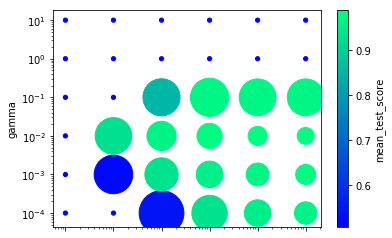

In [12]:
rbf10000 = rbf_df.xs(10000.0, level='max_iter').reset_index()
rbf10000.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=rbf10000['std_test_score']*200000, cmap='winter', logx=True, logy=True)

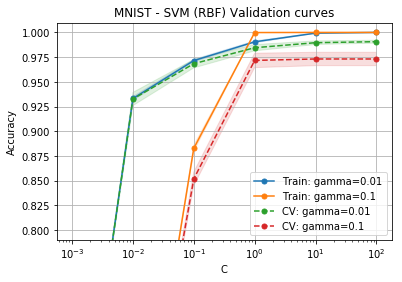

In [15]:
# Interesting cross sections above include gamma = 10^-1 and 10^-2
rbf_validation_curve1 = rbf_df.xs((10000.0, 0.01), level=('max_iter', 'gamma'))
rbf_validation_curve2 = rbf_df.xs((10000.0, 0.1), level=('max_iter', 'gamma'))
means = [rbf_validation_curve1['mean_train_score'], rbf_validation_curve2['mean_train_score'], rbf_validation_curve1['mean_test_score'], rbf_validation_curve2['mean_test_score']]
stds = [rbf_validation_curve1['std_train_score'], rbf_validation_curve2['std_train_score'], rbf_validation_curve1['std_test_score'], rbf_validation_curve2['std_test_score']]
labels = ['Train: gamma=0.01', 'Train: gamma=0.1', 'CV: gamma=0.01', 'CV: gamma=0.1']

plot_means_w_stds(means,stds,rbf_param_grid['C'], ylim=[0.79, 1.01], series_labels=labels, ylabel='Accuracy', xlabel='C', logx=True, title='MNIST - SVM (RBF) Validation curves', legend=True)


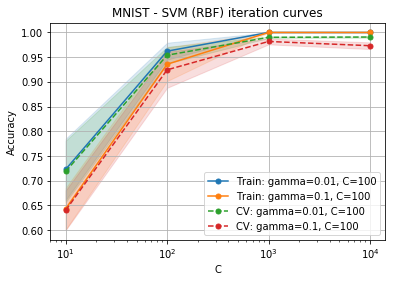

In [16]:
rbf_iter_curve1 = rbf_df.xs((100.0, 0.01), level=('C', 'gamma'))
rbf_iter_curve2 = rbf_df.xs((100.0, 0.1), level=('C', 'gamma'))
means = [rbf_iter_curve1['mean_train_score'], rbf_iter_curve2['mean_train_score'], rbf_iter_curve1['mean_test_score'], rbf_iter_curve2['mean_test_score']]
stds = [rbf_iter_curve1['std_train_score'], rbf_iter_curve2['std_train_score'], rbf_iter_curve1['std_test_score'], rbf_iter_curve2['std_test_score']]
labels = ['Train: gamma=0.01, C=100', 'Train: gamma=0.1, C=100', 'CV: gamma=0.01, C=100', 'CV: gamma=0.1, C=100']

plot_means_w_stds(means, stds, rbf_param_grid['max_iter'], series_labels=labels, ylabel='Accuracy', xlabel='C', logx=True, title='MNIST - SVM (RBF) iteration curves', legend=True)

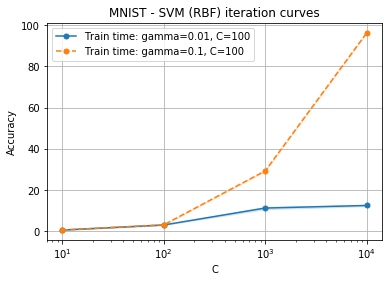

In [34]:
rbf_iter_curve1 = rbf_df.xs((100.0, 0.01), level=('C', 'gamma'))
rbf_iter_curve2 = rbf_df.xs((100.0, 0.1), level=('C', 'gamma'))
means = [rbf_iter_curve1['mean_fit_time'], rbf_iter_curve2['mean_fit_time']]
stds = [rbf_iter_curve1['std_fit_time'], rbf_iter_curve2['std_fit_time']]
labels = ['Train time: gamma=0.01, C=100', 'Train time: gamma=0.1, C=100']

plot_means_w_stds(means, stds, rbf_param_grid['max_iter'], series_labels=labels, ylabel='Accuracy', xlabel='C', logx=True, title='MNIST - SVM (RBF) iteration curves', legend=True)

### Analysis (linear)

In [17]:
# lin_res = linear_grid_search.cv_results_
lin_res = load_result_by_name('search_MNIST_SVM_0.968_2018-09-23_13-01-04-00_linear.pkl')
lin_df = scikit_cv_result_to_df(lin_res)

In [18]:
lin_df.sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
C    max_iter                                                                 
0.01 10.0           0.117976      0.011473         0.008166        0.008585   
     100.0          0.147295      0.013571         0.011999        0.008907   
     1000.0         0.151387      0.018114         0.002719        0.000138   
     10000.0        0.144668      0.006622         0.006615        0.004147   
0.10 10000.0        0.344841      0.032926         0.023015        0.020792   
     100.0          0.200431      0.019450         0.004579        0.003441   
     1000.0         0.308931      0.020765         0.005925        0.005831   
1.00 1000.0         0.555002      0.065529         0.007364        0.008015   
     10000.0        1.990991      0.134809         0.019609        0.005100   
0.10 10.0           0.132617      0.021615         0.003541        0.000885   

               mean_test_score  std_test_score  rank_test_score  \
C    max_iter                                                     
0.01 10.0             0.967969        0.001971                1   
     100.0            0.967969        0.002037                1   
     1000.0           0.967969        0.002037                1   
     10000.0          0.967969        0.002037                1   
0.10 10000.0          0.967140        0.003284                5   
     100.0            0.967140        0.003284                5   
     1000.0           0.967140        0.003284                5   
1.00 1000.0           0.963512        0.003381                8   
     10000.0          0.963201        0.003422                9   
0.10 10.0             0.962890        0.004085               10   

               mean_train_score  std_train_score  
C    max_iter                                     
0.01 10.0              0.973532         0.000591  
     100.0             0.973601         0.000655  
     1000.0            0.973601         0.000655  
     10000.0           0.973601         0.000655  
0.10 10000.0           0.980685         0.000635  
     100.0             0.980754         0.000726  
     1000.0            0.980685         0.000635  
1.00 1000.0            0.987492         0.001162  
     10000.0           0.987561         0.001374  
0.10 10.0              0.972911         0.004540

Text(0.5,1,'MNIST - Linear SVM CV scores')

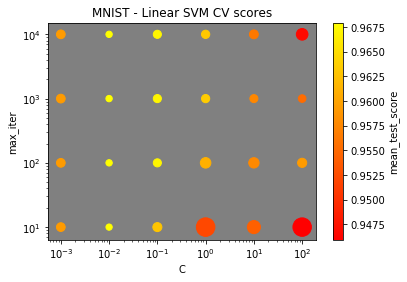

In [32]:
fig, ax = plt.subplots()
# lin_df = lin_df.reset_index()
lin_df.plot(ax=ax, kind='scatter', x='C', y='max_iter', c='mean_test_score', s=lin_df['std_test_score']*20000, cmap='autumn', logx=True, logy=True)
ax.set_facecolor('grey')
ax.set_title('MNIST - Linear SVM CV scores')

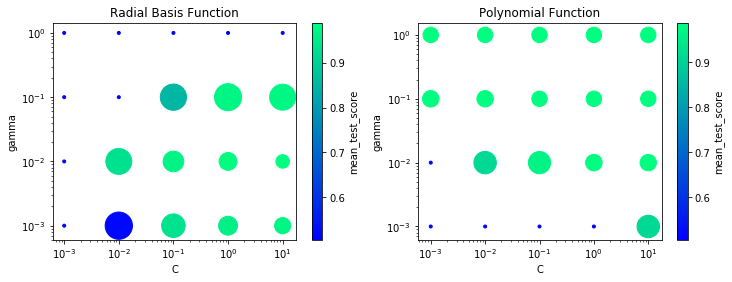

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=rbf['std_test_score']*100000, cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=poly['std_test_score']*100000, cmap='winter', logx=True, logy=True, ax=ax2)


# Gamma has no effect for linear kernel
# ax3.set_title('Linear Function')
# lin.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=lin['std_test_score']*100000, cmap='winter', logx=True, logy=True, ax=ax3)

In [113]:
# Helper function needed for std==0.0
def std_to_size(std):
    if std > 0:
        return std * 100
    else:
        return 10

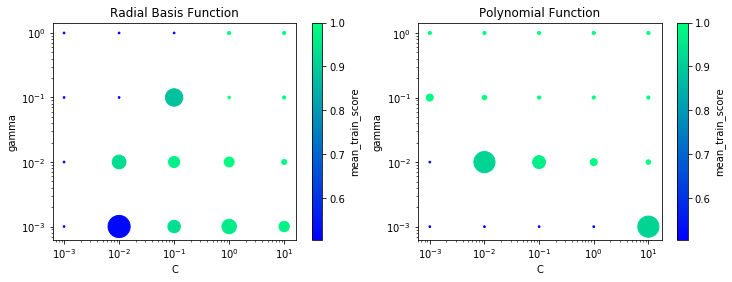

In [107]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=rbf['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=poly['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax2)

# ax3.set_title('Linear Function')
# lin.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=lin['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax3)

## SVM Learning Curve Analysis

In [29]:
# Find best estimator
best_clf = rbf_grid_search.best_estimator_
best_clf.get_params()

{'C': 100.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': 10000.0,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

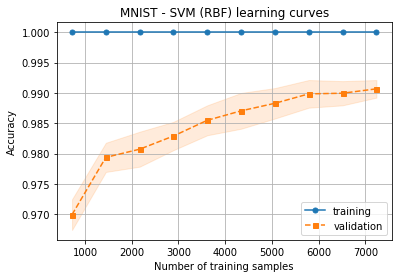

In [30]:
train_sizes, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(best_clf, X_train_scaled, y_train, scoring='accuracy', ylabel='Accuracy', cv=4, n_jobs=-1, title='MNIST - SVM (RBF) learning curves')

In [33]:
save_learning_curve(dataset, learner_type, train_sizes, train_mean, train_std, test_mean, test_std, extras='rbf')

# Test Set Performance

In [31]:
best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_test_pred)

In [32]:
print('%.4f' % test_score)

0.9911


### Timing statistics

In [ ]:
scipy.stats.describe(res['mean_fit_time'])

In [ ]:
scipy.stats.describe(res['mean_score_time'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

train_colors = ['blue', 'darkgreen', 'purple', 'navy', 'maroon']
test_colors = ['green', 'gold', 'coral', 'teal', 'magenta']

for ix, d in enumerate(param_grid['base_estimator__max_depth']):
    ax.plot(param_grid['n_estimators'], mean_fit[d],  label='max_depth %i' % d,
            marker='o', color=train_colors[ix], linestyle='-',
            markersize=5)
    ax.fill_between(param_grid['n_estimators'],
                  mean_fit[d] + std_fit[d],
                  mean_fit[d] - std_fit[d],
                  alpha=0.15, color=train_colors[ix])
plt.grid()
plt.legend(loc='lower right')
ax.set_ylabel('Fit time (sec)')
plt.xlabel('Number of weak learners')
plt.show()

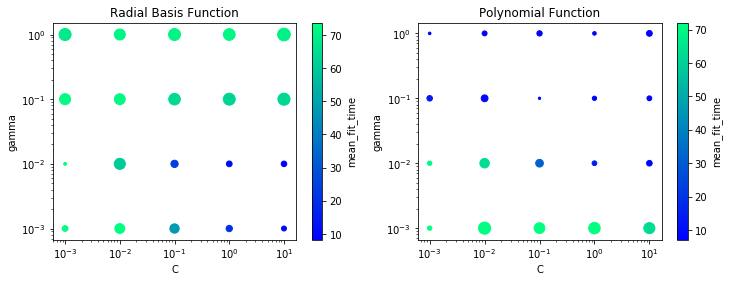

In [114]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_fit_time', s=rbf['std_fit_time'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_fit_time', s=poly['std_fit_time'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax2)